### Classification in Business

<center>
    <img src = 'images/uci_biz.png' />
</center>



------------


For this try-it, you are to explore some available datasets related to business applications of classification.  Using a dataset from the UCI Machine Learning Repository, scan datasets   under the subject area "BUSINESS" [link here](https://archive.ics.uci.edu/ml/datasets.php?format=&task=cla&att=&area=bus&numAtt=&numIns=&type=&sort=nameUp&view=table).  Find a dataset that looks interesting to you and decide how you could use Logistic Regression to help make a business decision using the data. 

In sharing your results, be sure to clearly describe the following:

- the dataset and its features
- the classification problem -- what are you classifying here?
- a business decision that can be supported using the results of the classification model

Share your summary on the appropriate discussion board for the activity. 

**Taiwanese Companies Bankruptcy Prediction using Logistic Regression**

**Business Understanding**
Bankruptcy prediction is critical for financial stability and risk management. By accurately identifying companies at risk of bankruptcy, stakeholders can take proactive measures to mitigate financial losses and protect investments.

**Objective:**
The objective of this project is to predict the likelihood of bankruptcy of Taiwanese companies based on financial and accounting data. The prediction will help financial institutions, investors, and stakeholders assess the risk associated with potential investments or existing clients.


**Data Understanding**
**Data Source:**
The dataset used for this project is sourced from the UCI Machine Learning Repository (ID: 572). It includes financial ratios and accounting-based metrics from Taiwanese companies, labeled with binary indicators (0 for non-bankrupt, 1 for bankrupt).

**Variables:**
**Features (X):** Financial ratios and metrics such as liquidity ratios, profitability ratios, leverage ratios, and operational ratios.<br>
**Target (y):** Binary indicator (0 or 1) representing bankruptcy status.

**Data Exploration:**
**Exploratory Data Analysis (EDA):** Carreid out to understand the distribution of features, detect outliers, and assess correlations between variables.
**Visualization:** histograms, pair plots, correlation matrices, confusion matrices, and area under the ROC (ROC-AUC) plotted in order to gain insights into the data.

**Data Preparation and Feature Engineering:**
**Data Cleaning:** Missing values, duplicated records, outliers, and inconsistencies in the dataset assesed.<br>
**Trasformations:** Features were normalized or standardized prior to modelling. L2 regularization for handling any multicollinear features. Due to shortage of time, no new features nor complex interactions between variables were derived.<br>
**Dataset:** Because of the low bankruptcy rate (220/6819), a sample of 1 record from X where y=1 for every 4 records from X where y=0 was selected (220/1100).<br>
**Train-Test Split:** Total sample size (N = 1100) was split into training (75%) and testing (25%) sets after shuffling.<br>
**Feature Selection:** Permutation importance with logistic regression was used to identify and keep only the most important 10 features.

**Modeling**
**Model Selection:** Logistic Regression chosen for its interpretability, ability to handle binary classification, and efficiency with structured data.<br>
**Model Training:** The logistic regression model was fit on the training data.
Tune hyperparameters if necessary (e.g., regularization strength) using cross-validation techniques.

**Evaluation**
**Model Evaluation Metrics:** Assessed accuracy, precision, recall, F1-score and ROC-AUC to understand model performance. The confusion matrix was assessed to understand true positives, true negatives, false positives, and false negatives.


In [69]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import make_column_transformer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import roc_curve, auc, precision_recall_curve, classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from scipy.stats import norm
from scipy.stats import norm, chi2
from sklearn.calibration import calibration_curve
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, roc_curve, auc, log_loss, classification_report

import mglearn
import researchpy as rp 
from sklearn.metrics import precision_score


from sklearn import set_config
set_config(display="diagram") #setting this will display your pipelines as seen above

import warnings
warnings.filterwarnings("ignore")

In [70]:
from ucimlrepo import fetch_ucirepo
import pandas as pd
import numpy as np

# Fetch dataset
taiwanese_bankruptcy_prediction = fetch_ucirepo(id=572)

# Data (as pandas dataframes)
X = taiwanese_bankruptcy_prediction.data.features
y = taiwanese_bankruptcy_prediction.data.targets

df_orig = pd.concat([X, y], axis=1)

# Convert y to 1D numpy array for indexing
y = y.values.ravel()

# Identify indices where y=1 and y=0
indices_y1 = np.where(y == 1)[0]
indices_y0 = np.where(y == 0)[0]

# Randomly sample 4 records from X where y=0 for every record where y=1
selected_indices_y0 = np.random.choice(indices_y0, size=4 * len(indices_y1), replace=True)
selected_indices = np.concatenate([indices_y1, selected_indices_y0])

# Create new DataFrame with selected records
X_selected = X.iloc[selected_indices]
y_selected = y[selected_indices]

# Reset index for X_selected DataFrame and create a new Series for y_selected
X_selected.reset_index(drop=True, inplace=True)
y_selected = pd.Series(y_selected, name='Bankrupt?')

df_new = pd.concat([X_selected, y_selected], axis=1)

# Print shape of the original data
print("Shape of original X:", X.shape)
print("Shape of original y:", y.shape)

# Print shape of the selected data
print("Shape of X_selected:", X_selected.shape)
print("Shape of y_selected:", y_selected.shape)

Shape of original X: (6819, 95)
Shape of original y: (6819,)
Shape of X_selected: (1100, 95)
Shape of y_selected: (1100,)


In [71]:
rp.summary_cat(df_orig['Bankrupt?'])

,Variable,Outcome,Count,Percent
0,Bankrupt?,0,6599,96.77
1,,1,220,3.23


In [72]:
rp.summary_cat(df_new['Bankrupt?'])

,Variable,Outcome,Count,Percent
0,Bankrupt?,0,880,80.0
1,,1,220,20.0


**Attributes**

In [73]:
X = X_selected
y = pd.Series(y_selected, name='Bankrupt?')

In [74]:
y.info()

<class 'pandas.core.series.Series'>
RangeIndex: 1100 entries, 0 to 1099
Series name: Bankrupt?
Non-Null Count  Dtype
--------------  -----
1100 non-null   int64
dtypes: int64(1)
memory usage: 8.7 KB


In [75]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1100 entries, 0 to 1099
Data columns (total 95 columns):
 #   Column                                                    Non-Null Count  Dtype  
---  ------                                                    --------------  -----  
 0    ROA(C) before interest and depreciation before interest  1100 non-null   float64
 1    ROA(A) before interest and % after tax                   1100 non-null   float64
 2    ROA(B) before interest and depreciation after tax        1100 non-null   float64
 3    Operating Gross Margin                                   1100 non-null   float64
 4    Realized Sales Gross Margin                              1100 non-null   float64
 5    Operating Profit Rate                                    1100 non-null   float64
 6    Pre-tax net Interest Rate                                1100 non-null   float64
 7    After-tax net Interest Rate                              1100 non-null   float64
 8    Non-industry inco

**Using Permutation Importance to reduce the number of features**

In [76]:
# Split the data with stratification
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

# Print the shapes of the resulting splits
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(825, 95) (275, 95) (825,) (275,)


In [77]:
# Initialize logistic regression model
model = LogisticRegression()

# Fit the model on the training data
model.fit(X_train, y_train)

# Evaluate model performance (optional)
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy of full Logistic Regression model: {accuracy}")

Accuracy of full Logistic Regression model: 0.7672727272727272


In [78]:
from sklearn.inspection import permutation_importance

# Calculate permutation importance
perm_importance = permutation_importance(model, X_test, y_test, n_repeats=10, random_state=42)

# Get the indices of feature importance in descending order
sorted_idx = perm_importance.importances_mean.argsort()[::-1]

# Print feature importance
for i in sorted_idx:
    print(f"{X.columns[i]}: {perm_importance.importances_mean[i]:.4f}")


 Fixed Assets Turnover Frequency: 0.0262
 Interest-bearing debt interest rate: 0.0062
 Cash/Current Liability: 0.0051
 Long-term Liability to Current Assets: 0.0040
 Quick Asset Turnover Rate: 0.0036
 Interest Expense Ratio: 0.0000
 Regular Net Profit Growth Rate: 0.0000
 Continuous Net Profit Growth Rate: 0.0000
 Net Value Growth Rate: 0.0000
 Total Asset Return Growth Rate Ratio: 0.0000
 Cash Reinvestment %: 0.0000
 Current Ratio: 0.0000
 Quick Ratio: 0.0000
 Average Collection Days: 0.0000
 Total Asset Turnover: 0.0000
 After-tax Net Profit Growth Rate: 0.0000
 Net worth/Assets: 0.0000
 Long-term fund suitability ratio (A): 0.0000
 Borrowing dependency: 0.0000
 Contingent liabilities/Net worth: 0.0000
 Operating profit/Paid-in capital: 0.0000
 Net profit before tax/Paid-in capital: 0.0000
 Inventory and accounts receivable/Net value: 0.0000
 Debt ratio %: 0.0000
 Equity to Liability: 0.0000
 Operating Profit Growth Rate: 0.0000
 Continuous interest rate (after tax): 0.0000
 ROA(A) b

In [79]:
# Number of top features to keep
k = 12

# Select the top k features
selected_features = X_train.columns[sorted_idx][:k]

X_selected = X_train[selected_features]
X_test = X_test[selected_features]

print(f"Selected features: {selected_features}")

Selected features: Index([' Fixed Assets Turnover Frequency',
       ' Interest-bearing debt interest rate', ' Cash/Current Liability',
       ' Long-term Liability to Current Assets', ' Quick Asset Turnover Rate',
       ' Interest Expense Ratio', ' Regular Net Profit Growth Rate',
       ' Continuous Net Profit Growth Rate', ' Net Value Growth Rate',
       ' Total Asset Return Growth Rate Ratio', ' Cash Reinvestment %',
       ' Current Ratio'],
      dtype='object')


In [80]:
print(X_selected.shape, y_train.shape)

(825, 12) (825,)


In [81]:
# Combine X_selected and y_train into a single DataFrame
df_plot = pd.concat([X_selected, y_train], axis=1)
print(df_plot.shape)
print(df_plot.info())

(825, 13)
<class 'pandas.core.frame.DataFrame'>
Index: 825 entries, 632 to 650
Data columns (total 13 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0    Fixed Assets Turnover Frequency        825 non-null    float64
 1    Interest-bearing debt interest rate    825 non-null    float64
 2    Cash/Current Liability                 825 non-null    float64
 3    Long-term Liability to Current Assets  825 non-null    float64
 4    Quick Asset Turnover Rate              825 non-null    float64
 5    Interest Expense Ratio                 825 non-null    float64
 6    Regular Net Profit Growth Rate         825 non-null    float64
 7    Continuous Net Profit Growth Rate      825 non-null    float64
 8    Net Value Growth Rate                  825 non-null    float64
 9    Total Asset Return Growth Rate Ratio   825 non-null    float64
 10   Cash Reinvestment %                    825 non-null   

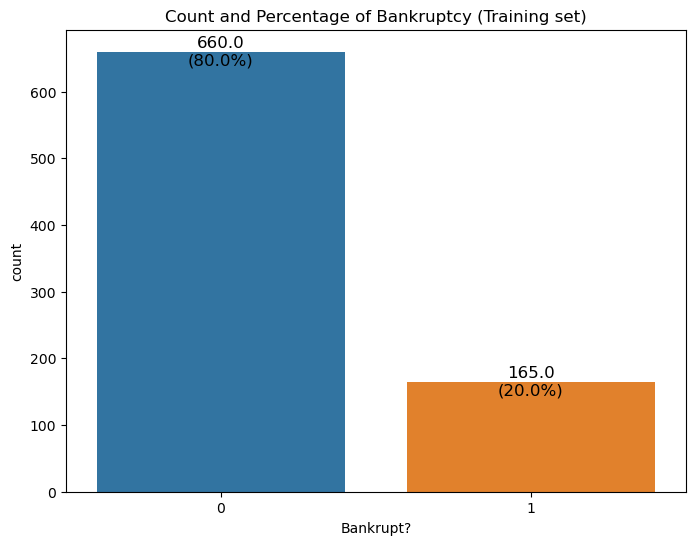

In [82]:
# Create a count plot
plt.figure(figsize=(8, 6))
ax = sns.countplot(data=df_plot, x='Bankrupt?')

# Add counts and percentages inside each bar
total = len(df_plot['Bankrupt?'])
for p in ax.patches:
    count = p.get_height()
    percentage = '{:.1f}%'.format(100 * count / total)
    x = p.get_x() + p.get_width() / 2.
    y = p.get_height()
    ax.annotate(f'{count}\n({percentage})', 
                (x, y), 
                ha='center', va='center', fontsize=12, color='black')

plt.title('Count and Percentage of Bankruptcy (Training set)')
plt.show()

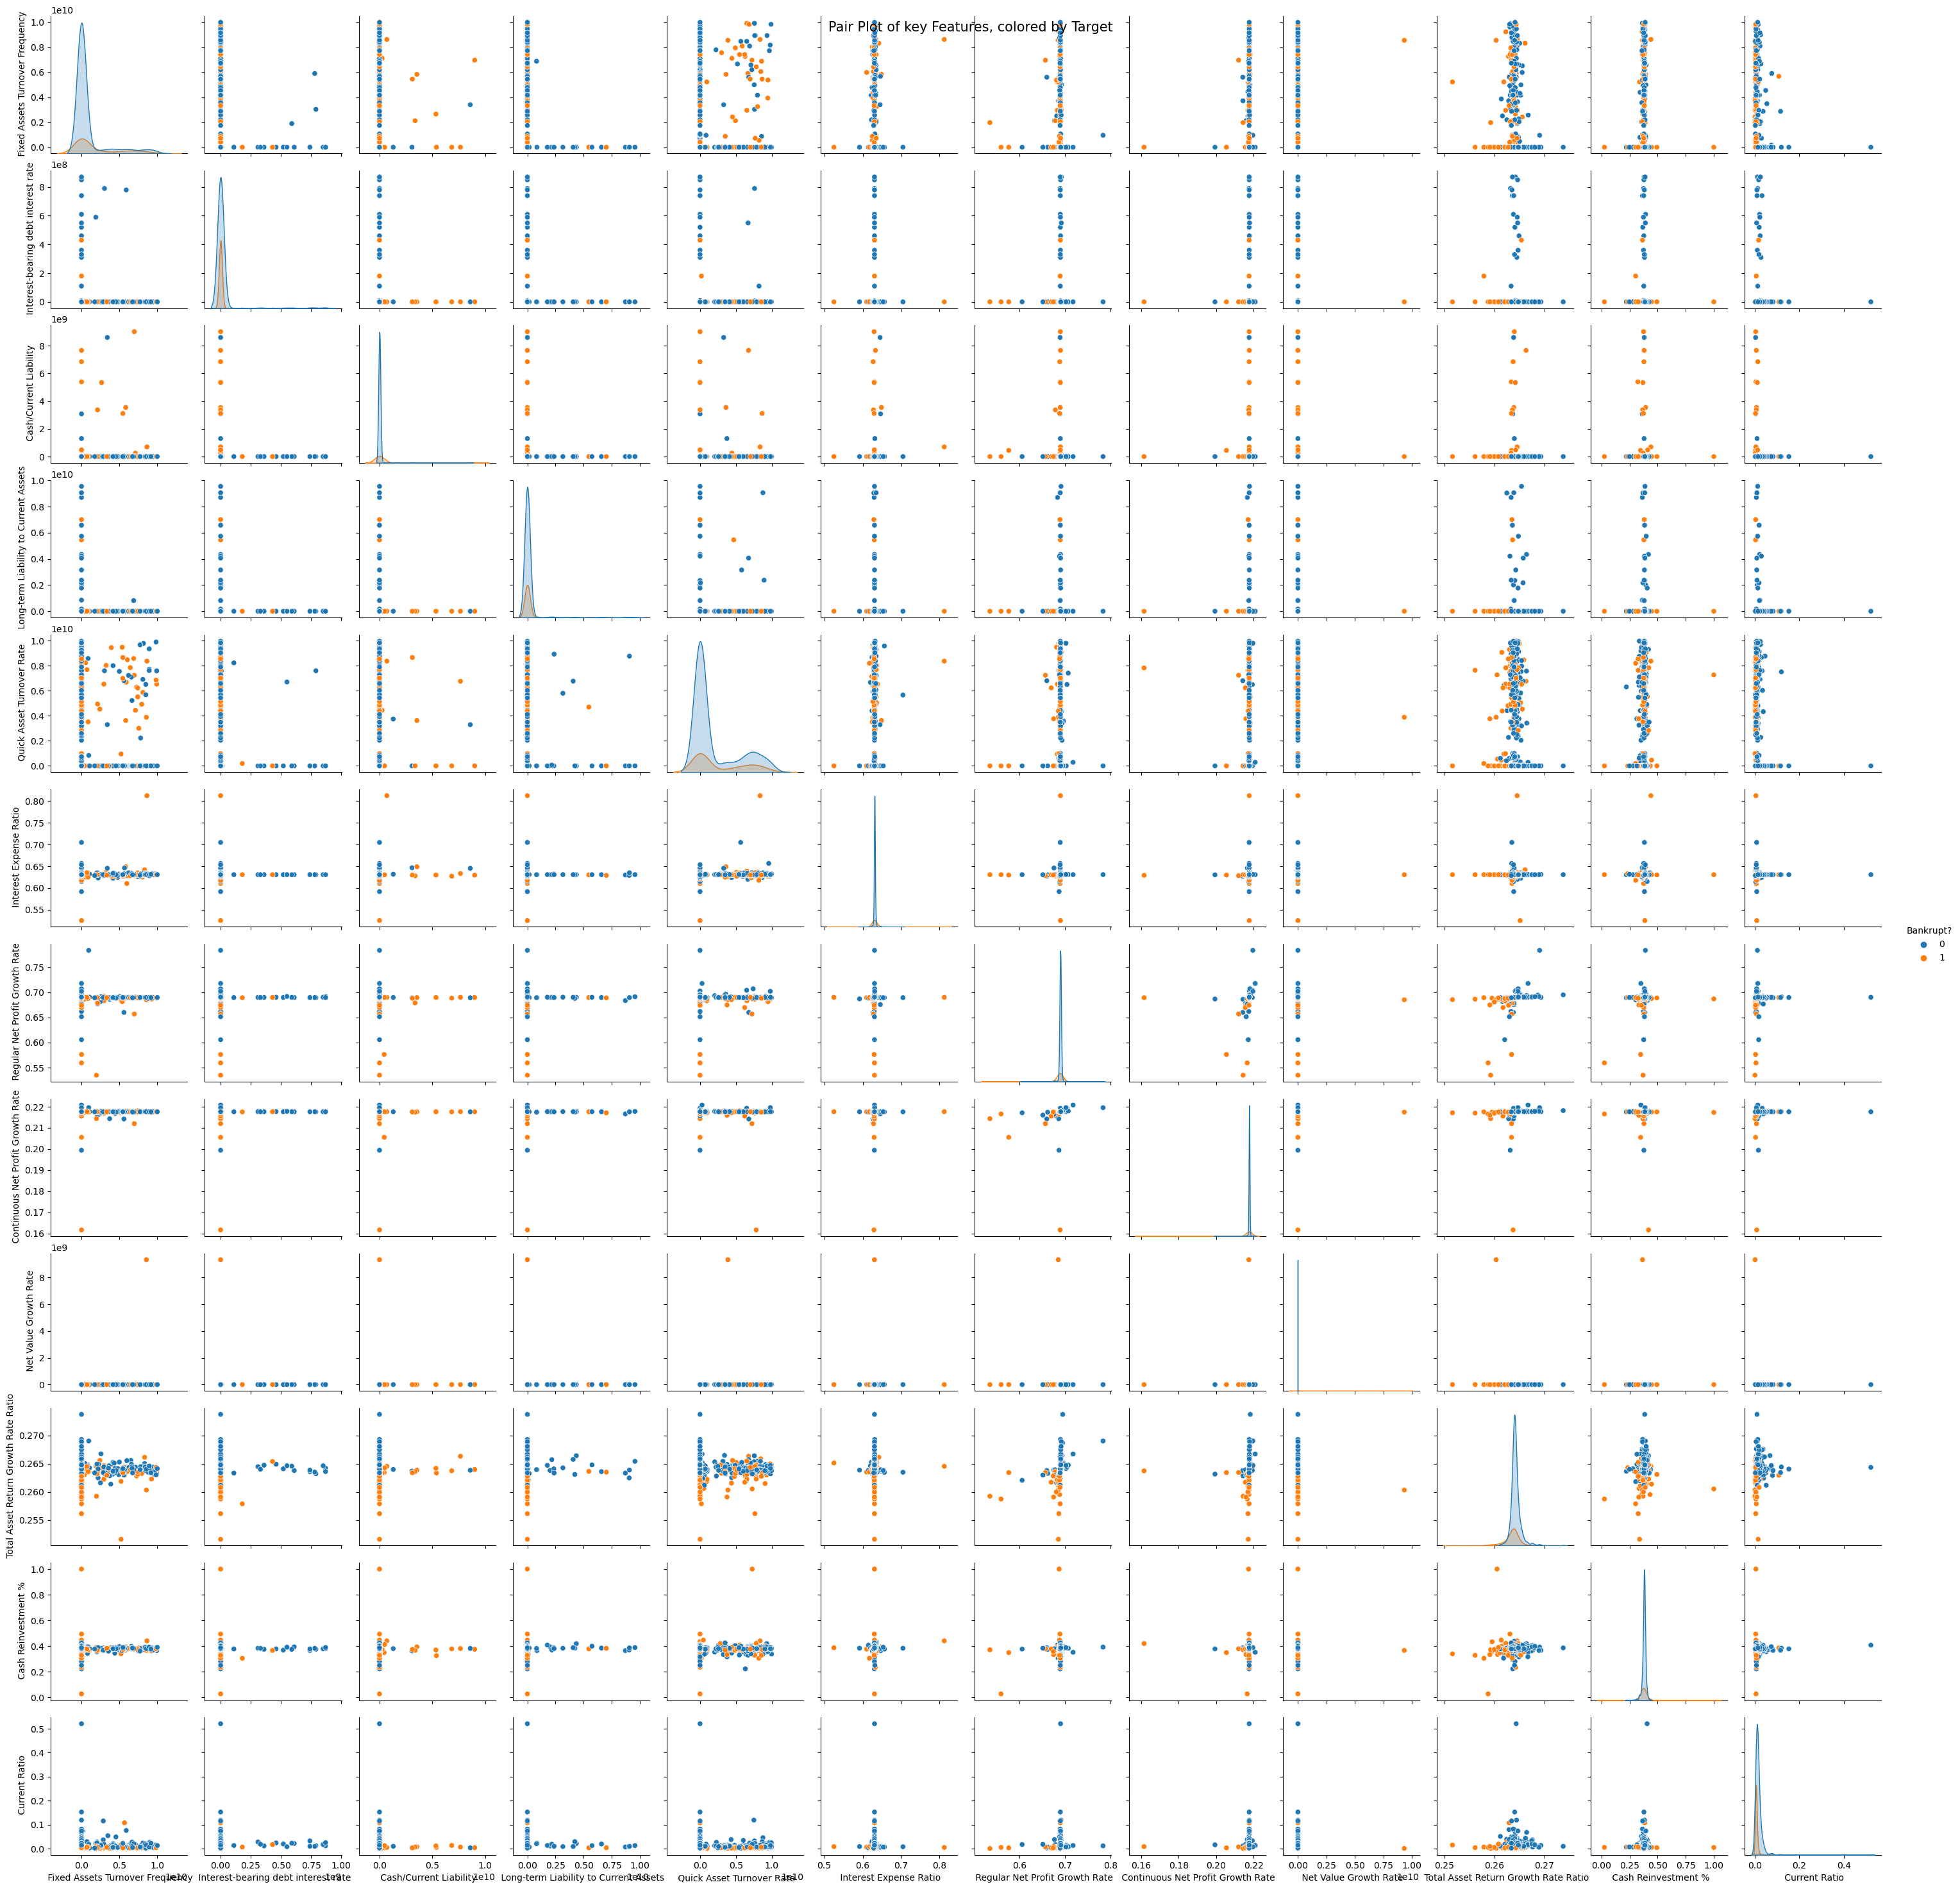

In [83]:
# Create a pair plot
sns.pairplot(df_plot, hue='Bankrupt?', height=2.5)
plt.suptitle('Pair Plot of key Features, colored by Target', size=15)
#plt.legend(loc='lower center', bbox_to_anchor=(0.5, -0.3), ncol=3)
plt.show()

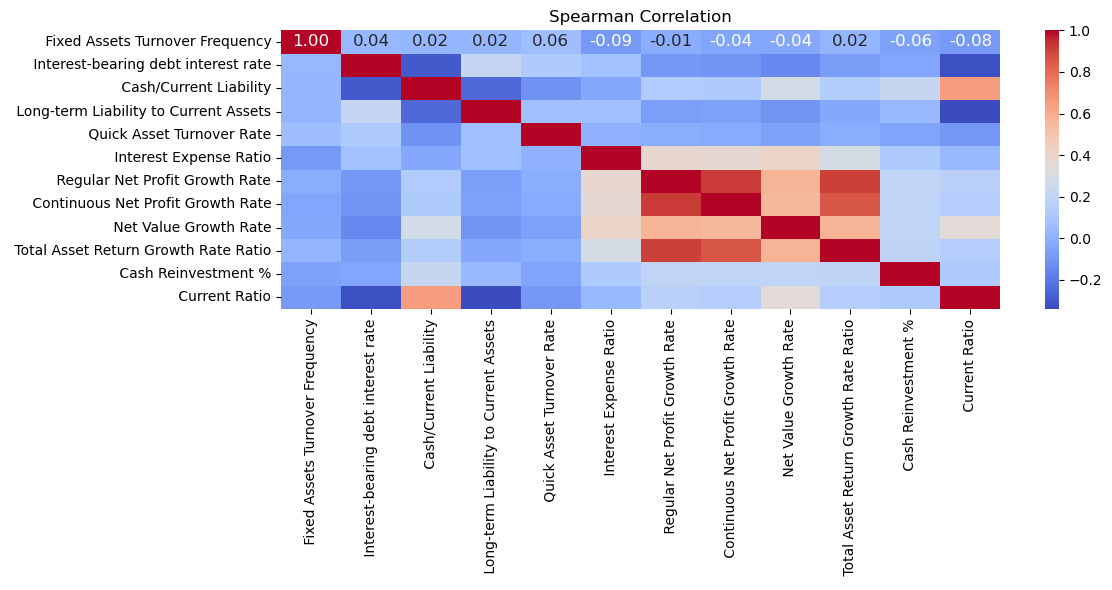

In [84]:
# Visualize correlations

# Calculate correlation matrix (Pearson and Spearman)
correlation_matrix_spearman = df_plot[selected_features].corr(method='spearman')

# Plot heatmap
plt.figure(figsize=(12, 6))

# Heatmap for Spearman correlations
sns.heatmap(correlation_matrix_spearman, annot=True, cmap='coolwarm', fmt=".2f", annot_kws={"size": 12})
plt.title('Spearman Correlation')

# Adjust layout to prevent overlap
plt.tight_layout()

# Rotate x-axis tick labels to 90 degrees
plt.xticks(rotation=90)

# Show plot
plt.show()

Keep correlated features to be handled by regularization

**Model building**

In [85]:
# Define the pipeline steps with L2 regularization
steps = [
    ('scaler', StandardScaler()),    # Step 1: StandardScaler
    ('logreg', LogisticRegression(penalty='l2', max_iter=1000, solver='liblinear', random_state=42))  # Step 2: LogisticRegression with L2 regularization
]

# Create the pipeline
pipeline = Pipeline(steps)

# Fit the pipeline on the training data
pipeline.fit(X_selected, y_train)


Pipeline(steps=[('scaler', StandardScaler()),
                ('logreg',
                 LogisticRegression(max_iter=1000, random_state=42,
                                    solver='liblinear'))])

Parameter Estimates:
                               Feature     Coef.  Std. Err.          Z      p > |Z|  95% CI (lower)  95% CI (upper)
       Fixed Assets Turnover Frequency  0.212965   0.035456   6.006416 1.896697e-09        0.143471        0.282459
   Interest-bearing debt interest rate -0.106785   0.034874  -3.061977 2.198802e-03       -0.175138       -0.038431
                Cash/Current Liability  0.307474   0.035015   8.781286 0.000000e+00        0.238845        0.376103
 Long-term Liability to Current Assets -0.050827   0.034897  -1.456465 1.452642e-01       -0.119226        0.017572
             Quick Asset Turnover Rate  0.158682   0.035314   4.493490 7.006548e-06        0.089467        0.227897
                Interest Expense Ratio -0.091675   0.035188  -2.605272 9.180124e-03       -0.160643       -0.022706
        Regular Net Profit Growth Rate -0.093450   0.038074  -2.454434 1.411065e-02       -0.168076       -0.018825
     Continuous Net Profit Growth Rate -0.142537   

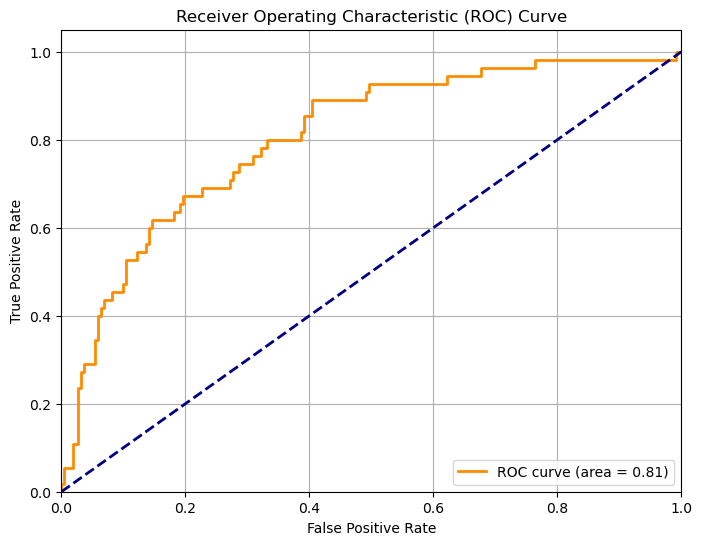

[[214   6]
 [ 42  13]]


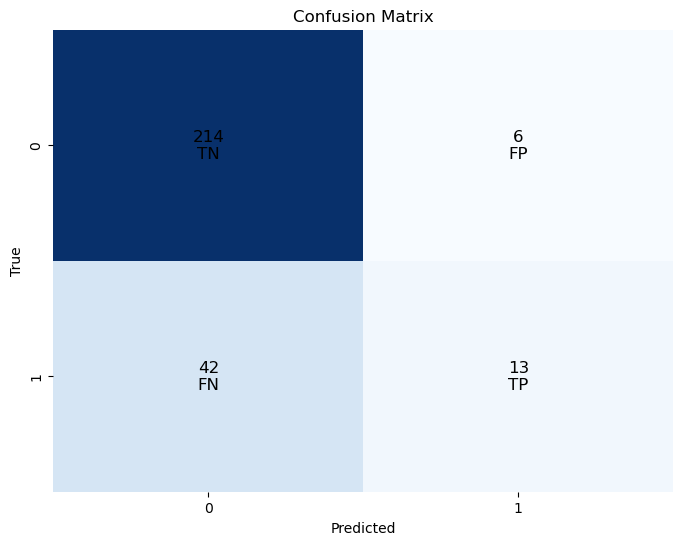

In [88]:

# Fit the pipeline on the training data
pipeline.fit(X_selected, y_train)

# Extract the logistic regression model from the pipeline
logistic_regression_model = pipeline.named_steps['logreg']

# Extract the StandardScaler from the pipeline
scaler = pipeline.named_steps['scaler']

# Transform X_selected using the scaler
X_scaled = scaler.transform(X_selected)

# Extracting coefficient estimates, standard errors, z-scores, p-values, and confidence intervals
coef = logistic_regression_model.coef_[0]
std_err = np.sqrt(np.diag(np.linalg.inv(X_scaled.T @ X_scaled)))  # Standard errors using the inverse of (X'X)
z_scores = coef / std_err
p_values = 2 * (1 - norm.cdf(np.abs(z_scores)))
conf_int = np.column_stack((coef - 1.96 * std_err, coef + 1.96 * std_err))

# Retrieve feature names
feature_names = X_selected.columns

# Calculate model equation including intercept
intercept = logistic_regression_model.intercept_[0]
model_equation = f"log(p / (1 - p)) = {intercept:.4f} + " + \
                " + ".join([f"({coef[i]:.4f} * {feature_names[i]})" for i in range(len(coef))])

# Calculate log-likelihood (useful for logistic regression)
log_likelihood = logistic_regression_model.score(X_scaled, y_train)  # This computes the mean accuracy

# Number of observations (N)
N = X_selected.shape[0]

# Likelihood ratio chi-squared (LR chi2) and its p-value
LR_chi2 = 2 * log_likelihood * N  # Likelihood ratio statistic
prob_chi2 = chi2.sf(LR_chi2, len(coef))  # p-value associated with LR chi2

# Hosmer-Lemeshow Goodness-of-fit test
from sklearn.calibration import calibration_curve

# Predict probabilities on the training set
y_pred_prob = pipeline.predict_proba(X_selected)[:, 1]

# Calculate observed and expected frequencies
observed_prob, predicted_prob = calibration_curve(y_train, y_pred_prob, n_bins=10, strategy='uniform')
observed_freq = np.histogram(y_pred_prob, bins=10)[0]
expected_freq = predicted_prob * observed_freq.sum()

# Compute Hosmer-Lemeshow chi-squared statistic
HL_chi2 = ((observed_freq - expected_freq) ** 2 / expected_freq).sum()

# Degrees of freedom for the Hosmer-Lemeshow test
df = 10 - 2  # 10 deciles minus 2 parameters (intercept and slope)

# Compute p-value using chi2 distribution
HL_p_value = chi2.sf(HL_chi2, df)

# Compute evaluation metrics on the test set
y_pred = pipeline.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, pipeline.predict_proba(X_test)[:, 1])  # Use predict_proba for ROC-AUC

# Print all the computed statistics
print("Parameter Estimates:")
param_df = pd.DataFrame({'Feature': feature_names, 'Coef.': coef, 'Std. Err.': std_err, 'Z': z_scores, 'p > |Z|': p_values,
                         '95% CI (lower)': conf_int[:, 0], '95% CI (upper)': conf_int[:, 1]})
print(param_df.to_string(index=False))  # Print parameter estimates table without index

print("\nModel Equation:\n", model_equation)
print("\nLog-Likelihood:", log_likelihood)
print("Number of Observations (N):", N)
print("LR Chi-squared:", LR_chi2)
print("Prob > Chi-squared:", prob_chi2)
print("\nHosmer-Lemeshow Test:")
print(f"HL Chi-squared: {HL_chi2:.4f}")
print(f"HL Degrees of Freedom: {df}")
print(f"HL p-value: {HL_p_value:.4f}")

print("\nModel Evaluation on Test Set:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")
print(f"ROC-AUC: {roc_auc:.4f}")

# Classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Plot ROC curve
fpr, tpr, thresholds = roc_curve(y_test, pipeline.predict_proba(X_test)[:, 1])
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


# Plot confusion matrix with TP, FP, TN, FN labels inside cells
print(confusion_matrix(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=False, cmap='Blues', cbar=False, annot_kws={"size": 16})  # Use 'fmt=d' for integer display

# Label True Positives and False Positives inside cells
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j + 0.5, i + 0.5, f"{cm[i, j]}\n{['TN', 'FP', 'FN', 'TP'][i * cm.shape[1] + j]}",
                 ha='center', va='center', fontsize=12, color='black')

plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()



**Model Interpretation Summary:**<br>

The logistic regression model shows a high log-likelihood and significant LR chi-squared statistic, indicating a good fit to the data and statistical significance of the predictors. However, the HL test suggests a lack of fit, indicating that predicted probabilities do not match observed frequencies well across groups.

The model's performance metrics on the test set (accuracy, precision, recall, f1-score, ROC-AUC) show promising results, with accuracy of 0.8255 indicating overall good predictive performance, especially for class 0 (non-bankrupt companies).

Overall, while the model demonstrates statistical significance and reasonable predictive performance, the discrepancy highlighted by the Hosmer-Lemeshow (HL) test warrants further investigation into potential model refinement or data considerations.

**Interpretation of parameter estimates:**<br> <br>
**Fixed Assets Turnover Frequency:** A higher turnover frequency of fixed assets (Coef. = 0.2130) is associated with an increased log-odds of bankruptcy (p< 0.001). Companies with more frequent turnover of fixed assets are more likely to be predicted as bankrupt.

**Interest-bearing debt interest rate:** A higher interest-bearing debt interest rate (Coef. = -0.1068) is associated with a decreased log-odds of bankruptcy (p = 0.002). Companies with higher interest rates on their debt are less likely to be predicted as bankrupt. This could indicate that despite higher costs of borrowing (higher interest rates), these companies are able to secure financing to cover their obligations, thereby reducing the likelihood of bankruptcy.

**Cash/Current Liability:** A higher ratio of cash to current liabilities (Coef. = 0.3075) is associated with an increased log-odds of bankruptcy (p > < 0.001). Companies with higher cash reserves relative to their current liabilities are more likely to be predicted as bankrupt. Maintaining excessively high cash reserves may indicate operational inefficiencies or lack of effective financial planning. Companies might hoard cash due to uncertainties or inability to deploy funds into productive investments or growth opportunities.

**Long-term Liability to Current Assets:** A higher ratio of long-term liabilities to current assets (Coef. = -0.0508) shows a slight decrease in the log-odds of bankruptcy, but this effect is not statistically significant (p = 0.145).

**Quick Asset Turnover Rate:** A higher rate of turnover for quick assets (Coef. = 0.1587) is associated with an increased log-odds of bankruptcy (p > < 0.001). Companies that efficiently turn over their quick assets are more likely to be predicted as bankrupt. High turnover of quick assets might involve liquidating these assets frequently to fund operations or pay debts. While this can provide short-term relief, frequent asset liquidation could signal an inability to generate sustainable revenue or profitability through core business operations.

**Interest Expense Ratio:** A higher interest expense ratio (Coef. = -0.0917) is associated with a decreased log-odds of bankruptcy (p = 0.009). Companies with lower interest expenses relative to their earnings are less likely to be predicted as bankrupt.

**Regular Net Profit Growth Rate, Continuous Net Profit Growth Rate, Net Value Growth Rate: Higher growth rates** (Coef. = -0.0935, -0.1425, 0.1179 respectively) indicate mixed effects on bankruptcy prediction, with the regular and continuous net profit growth rates showing slight decreases in the log-odds (p < 0.05), while net value growth rate shows a slight increase (p = 0.001).

**Total Asset Return Growth Rate Ratio:** A higher ratio of total asset return growth rate (Coef. = -0.9108) is strongly associated with a decreased log-odds of bankruptcy (p < 0.001). Companies with higher returns on their total assets are significantly less likely to be predicted as bankrupt.

**Cash Reinvestment %:** The percentage of cash reinvestment (Coef. = -0.0150) shows a negligible effect on bankruptcy prediction (p = 0.675). This feature is not statistically significant.

**Current Ratio:** A higher current ratio (Coef. = -2.8550) is strongly associated with a decreased log-odds of bankruptcy (p < 0.001). Companies with higher current ratios are significantly less likely to be predicted as bankrupt.